### 1. KITTI 데이터셋 분석

#### 1) Imports

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

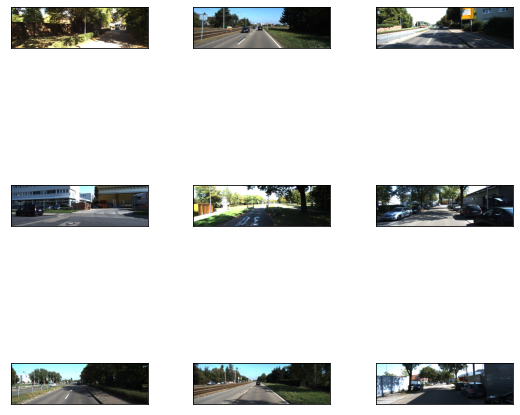

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj51/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

#### 2) 데이터 확인해보기

In [5]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-1.57, -2.08, -2.02, -2.25, -2.25, -1.7 , -1.55, -1.78,  2.23],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.39072   , 0.4691063 , 0.5112    , 0.5134058 ],
       [0.22586666, 0.16069244, 0.56626666, 0.3483575 ],
       [0.29925334, 0.24628824, 0.5637867 , 0.3707971 ],
       [0.37325335, 0.31165057, 0.51176   , 0.40289855],
       [0.40493333, 0.34088567, 0.55      , 0.4252657 ],
       [0.41533333, 0.52987117, 0.5918933 , 0.58776975],
       [0.44256   , 0.4702335 , 0.52602667, 0.49786633],
       [0.00266667, 0.        , 0.6708    , 0.14388889],
       [0.31493333, 0.        , 0.67413336, 0.13854267]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.36, 1.69, 3.38],
       [1.76, 1.74, 4.16],
       [1.83, 1.64, 3.71],
       [1.5 , 1.58, 3.57],
       [1.8 , 1.63, 3.79],
  

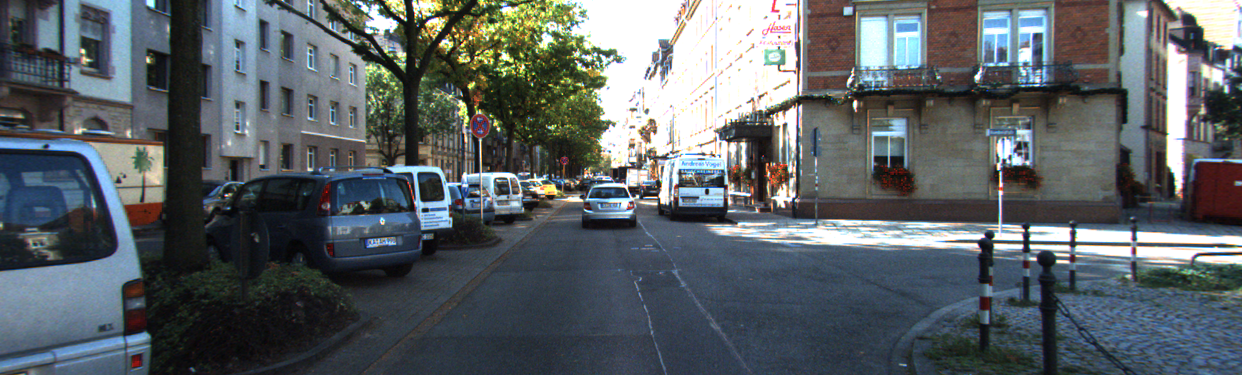

In [6]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

#### 3) 이미지에 Bounding Box 시각화

width : 1242, height : 375

이미지 내에 있는 bounding box : 9개
[[582.63    228.48    637.65    183.3    ]
 [199.58    290.3     432.66    162.65001]
 [305.88998 262.78    460.53    163.57999]
 [387.07    235.03    500.4     183.09   ]
 [423.38    223.15    528.18    168.75   ]
 [658.1     219.25    730.01    153.04001]
 [584.03    209.04001 618.35    177.74   ]
 [  0.      374.      178.71    123.45001]
 [  0.      256.9     172.06999 122.2    ]]
[582.63 228.48 637.65 183.3 ]
[199.58    290.3     432.66    162.65001]
[305.88998 262.78    460.53    163.57999]
[387.07 235.03 500.4  183.09]
[423.38 223.15 528.18 168.75]
[658.1     219.25    730.01    153.04001]
[584.03    209.04001 618.35    177.74   ]
[  0.      374.      178.71    123.45001]
[  0.      256.9     172.06999 122.2    ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F387C347490>


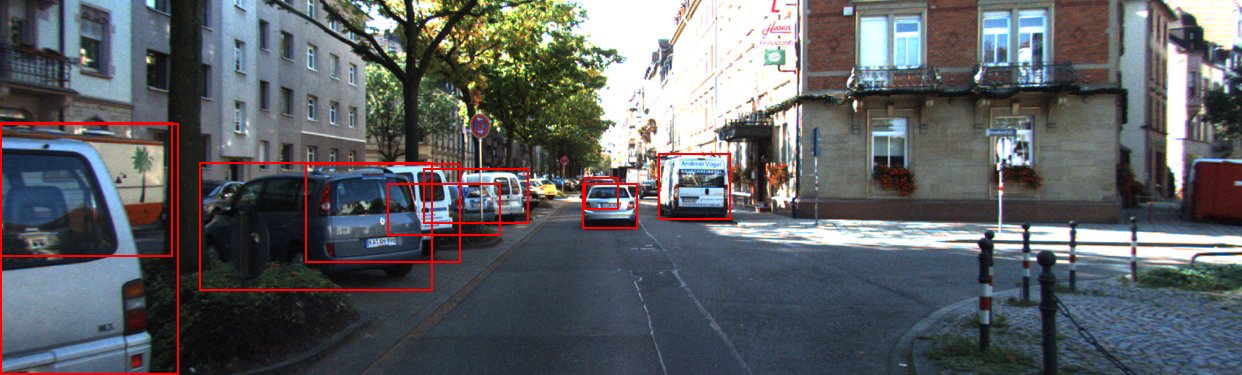

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

        # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(f'width : {width}, height : {height}')
    print(f'\n이미지 내에 있는 bounding box : {object_bbox.shape[0]}개')
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

        # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    print(rects)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 2. 자율주행 시스템 만들기

In [10]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join(os.getenv("HOME"),'aiffel','object_detection', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    result = "Go"
    image = read_image_bgr(img_path)
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0:(0,0,255),
        1:(255,0,0)
    }
    
    # 이미지 전처리
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # peocess image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)
            
            if b[2]-b[0] >= 300 or b[3]-b[1] >= 300 or label == 1 :
                result = 'Stop'
            else:
                result = 'Go'

            draw_box(draw, b, color=color_map[label])
            
            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=20)
        plt.imshow(draw)
        plt.show()
    
        return result

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[  0.      199.7626  305.84277 369.12827]
[749.2799  161.34863 884.51385 214.32716]


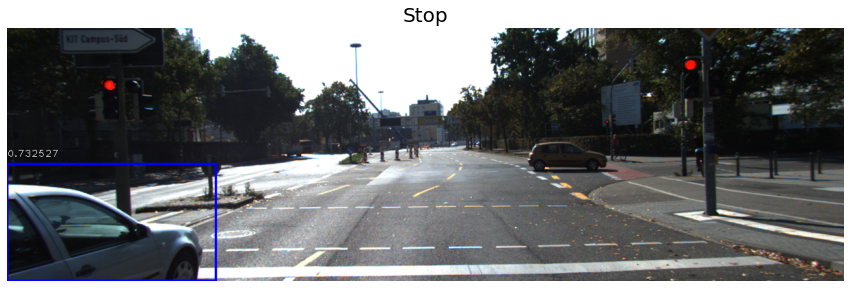

Stop


In [12]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
print(self_drive_assist(model=model,img_path=img_path))

### 3. 자율주행 시스템 평가하기

In [13]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

/home/aiffel-dj51/aiffel/object_detection/test_set/stop_1.png
[774.2992  149.30692 842.58307 318.57483]
[773.45245 155.14684 847.37354 307.4928 ]


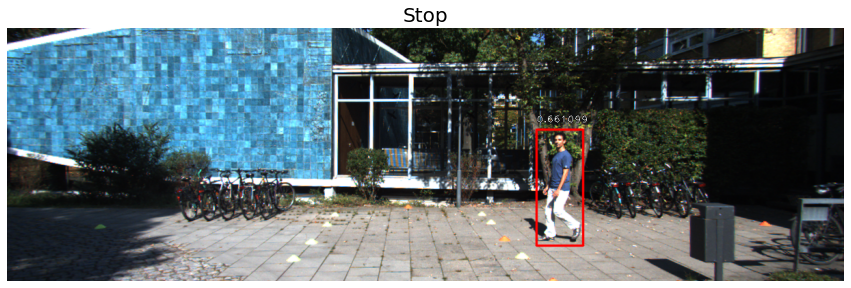

/home/aiffel-dj51/aiffel/object_detection/test_set/stop_2.png
[418.16837 160.80888 491.626   330.78552]
[421.47583 159.53131 494.77585 329.18442]


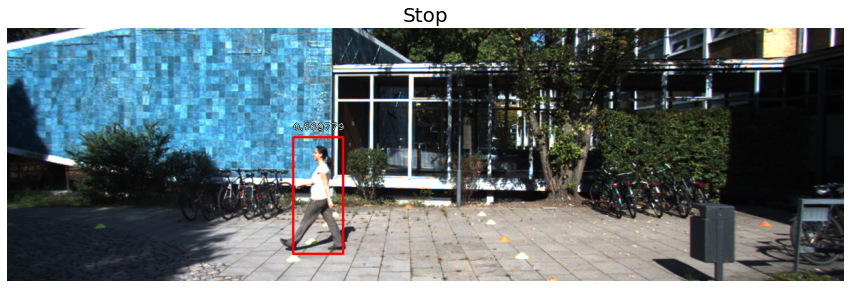

/home/aiffel-dj51/aiffel/object_detection/test_set/stop_3.png
[  0.      199.7626  305.84277 369.12827]
[749.2799  161.34863 884.51385 214.32716]


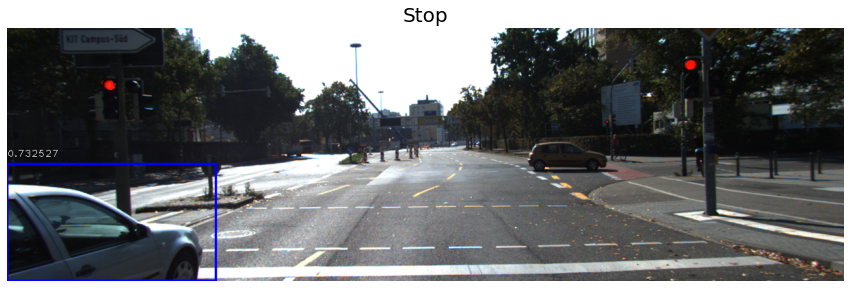

/home/aiffel-dj51/aiffel/object_detection/test_set/stop_4.png
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[ 723.8766     61.782776 1118.5337    349.616   ]
[ 75.683784 161.72188  370.07526  311.56808 ]


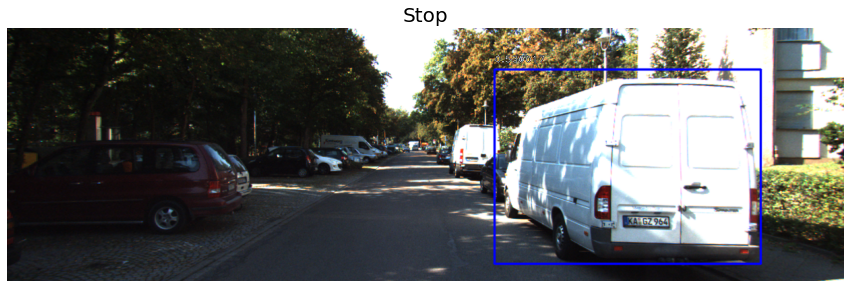

/home/aiffel-dj51/aiffel/object_detection/test_set/stop_5.png
[ 865.1253  180.0475 1241.0684  372.6204]
[567.7254  181.17926 611.9372  217.91183]


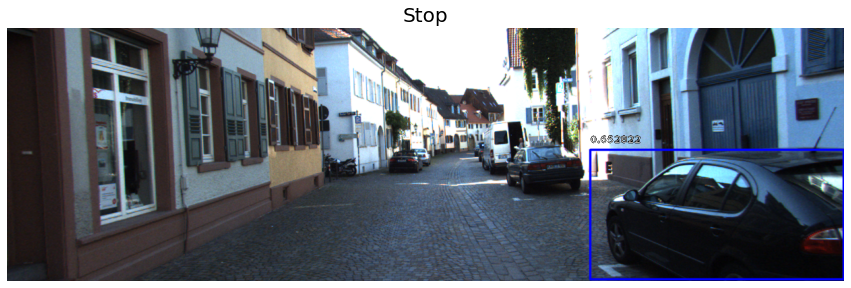

/home/aiffel-dj51/aiffel/object_detection/test_set/go_1.png
[593.92883 176.50821 624.3762  206.03746]
[190.01187 135.92944 340.03824 241.30223]


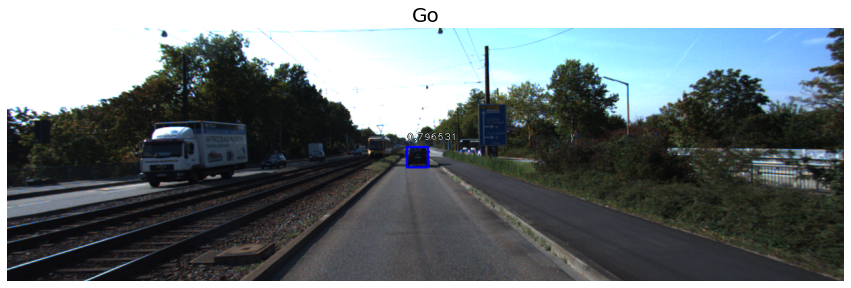

/home/aiffel-dj51/aiffel/object_detection/test_set/go_2.png
[626.55457 173.61157 668.6209  214.16148]
[617.93677 169.7709  654.275   212.7256 ]


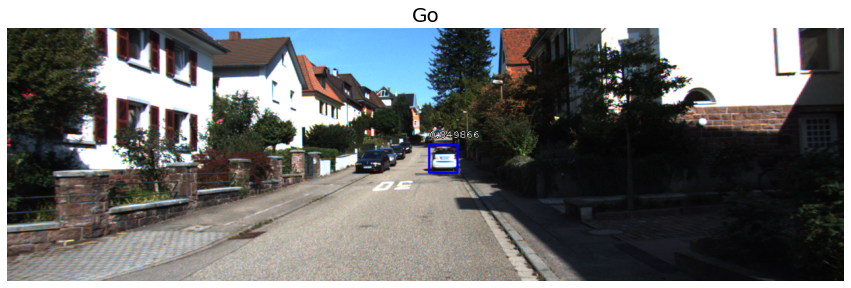

/home/aiffel-dj51/aiffel/object_detection/test_set/go_3.png
[801.5029  147.57043 882.3573  183.14554]


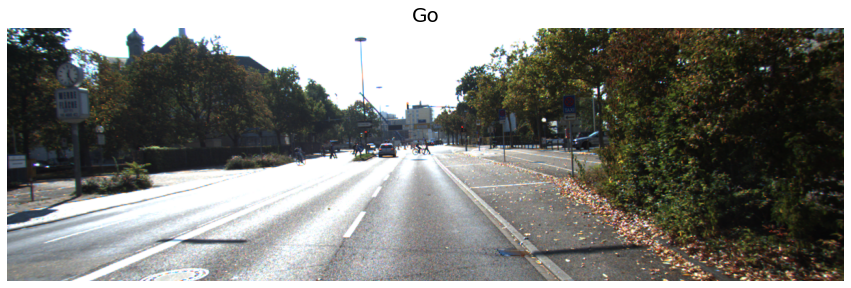

/home/aiffel-dj51/aiffel/object_detection/test_set/go_4.png
[698.00555 172.46518 785.667   251.95602]


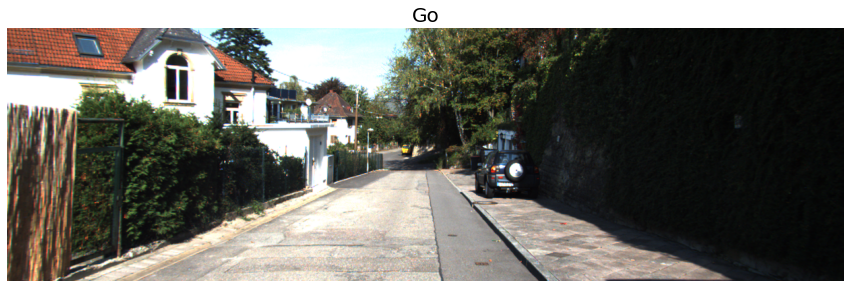

/home/aiffel-dj51/aiffel/object_detection/test_set/go_5.png
[ 10.412616 184.20166  221.46457  310.8126  ]


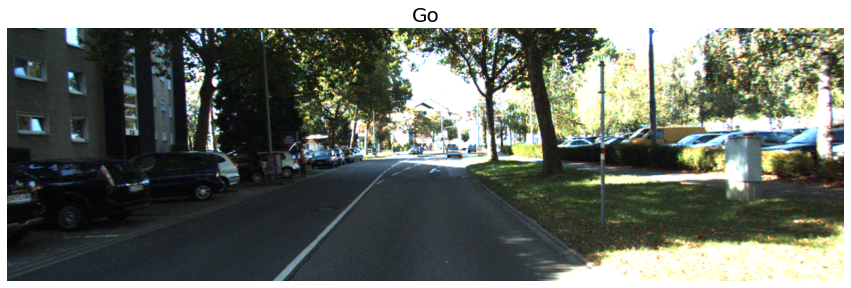

100점입니다.


In [14]:
test_system(self_drive_assist)

### 느낀점(회고)

In [ ]:
총 10개의 사진 중에서 10개의 사진에 대해서 맞추었고 100퍼센트의 정확도를 보여주었다.